In [7]:
import os
import warnings
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom

from config_manager import get_directory
from data_io import ScanDataGenerator
from fast_mri_view import show_slices
from scan_augmentor import ScanAugmentor
import pandas as pd
import pickle

In [8]:
def ScanDataConventor(input_h5=None, input_h5_keys='imgdata/mprage', input_h5_key_ids='labels/img_id', crop = ((0, 0),(0, 0), (0, 0)), zooms=1.0, dtype='f8',augment=False, output_h5=None):
    '''
    function to crop and scale images from an h5 and save them to an h5
    '''
    with h5py.File(input_h5, 'r') as r:
        shape = r[input_h5_keys].shape
        img_ids = (r[input_h5_key_ids][:][:]).tolist()
    n, x, y, z = shape[0], shape[1], shape[2], shape[3] 
    d1, d2, d3 = (x-crop[0][0]-crop[0][1]), (y-crop[1][0]-crop[1][1]), (z-crop[2][0]-crop[2][1])
    shape_cropped = (n, d1, d2, d3)
    shape_zoomed = (n, int(np.round(shape_cropped[1]*zooms)),int(np.round(shape_cropped[2]*zooms)),int(np.round(shape_cropped[3]*zooms)))
    
    with h5py.File(output_h5, 'w') as w:
        w.create_group(input_h5_key_ids.split('/')[0])
        w.create_group(input_h5_keys.split('/')[0])
        labels = w.create_dataset(input_h5_key_ids, maxshape = (None,None), shape=(n, 1), dtype=int , data=img_ids ,compression="lzf")
        out_scan = w.create_dataset(input_h5_keys, maxshape = (None,None,None,None), shape=(n, shape_zoomed[1], shape_zoomed[2], shape_zoomed[3]), dtype=dtype, 
                                        chunks=(1, shape_zoomed[1], shape_zoomed[2], shape_zoomed[3]) ,compression="lzf")
    
        for scan in range(len(range(n))):
            with h5py.File(input_h5, 'r') as r:
                scan_data = r[input_h5_keys][scan, :, :, :]
                r.close()
            if augment:
                scan_data = ScanAugmentor().augment(scan_data)
            if crop != ((0,0),(0,0),(0,0)): 
                scan_cropped = np.empty((d1, d2, d3))
                scan_cropped[:,:,:] = scan_data[crop[0][0]:(x-crop[0][1]), crop[1][0]:(y-crop[1][1]), crop[2][0]:(z-crop[2][1])]
            else:
                scan_cropped = scan_data
            
            if zooms != 1:            
                scan_zoom = zoom(scan_cropped[:, :, :], zooms)
            else:
                scan_zoom = scan_cropped
    
            out_scan[scan, :, :, :] = scan_zoom
            if scan % 200==0:
                print('{} out of {} processed.'.format(scan, n))
        w.flush()
        w.close()

In [ ]:
ScanDataConventor(input_h5=get_directory.adni_mprage_h5, output_h5='/mnt/lippert01/mri_backup/adni/adni_mprage/augmented/adni_mprage_ventricles_augmented.h5', crop=((68,68),(50,86),(88,48)), zooms=.8, augment=True)

0 out of 17236 processed.
200 out of 17236 processed.
400 out of 17236 processed.
600 out of 17236 processed.
800 out of 17236 processed.
1000 out of 17236 processed.
1200 out of 17236 processed.
1400 out of 17236 processed.
1600 out of 17236 processed.
1800 out of 17236 processed.
2000 out of 17236 processed.
2200 out of 17236 processed.
2400 out of 17236 processed.
2600 out of 17236 processed.
2800 out of 17236 processed.
3000 out of 17236 processed.


In [9]:
from fast_mri_view import show_slices

In [ ]:
df =pd.read_csv(get_directory.adni_mprage_dataframe)

with open(get_directory.adni_mprage_dict, 'rb') as pk:
            imgid = pickle.load(pk)
img = ScanDataGenerator(get_directory.adni_mprage_h5,img_id=df.Image_ID[30:31],dataframe=get_directory.adni_mprage_dataframe,input_dim=(256,256,256),img_to_i=imgid)
np_img = np.array(img)
np_img = np_img[0,0,0,:,:,:,0]

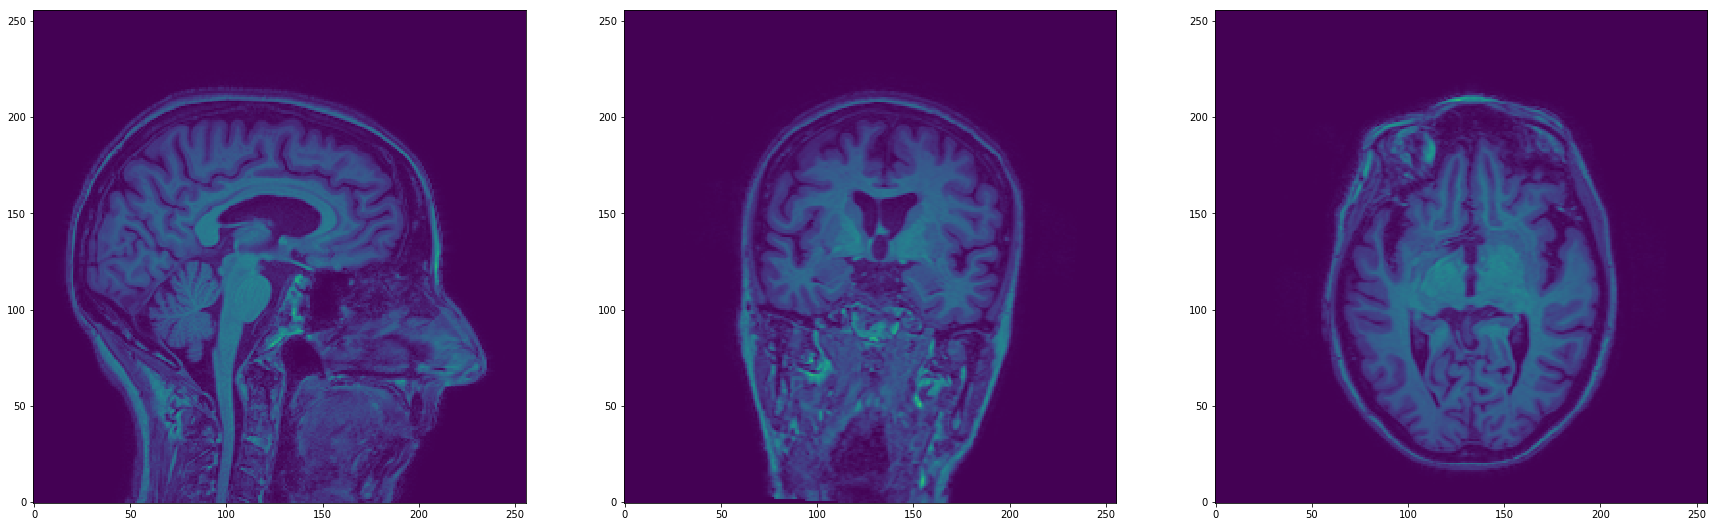

In [10]:
df =pd.read_csv(get_directory.adni_mprage_dataframe)

with open(get_directory.adni_mprage_dict, 'rb') as pk:
            imgid = pickle.load(pk)
img = ScanDataGenerator(get_directory.adni_mprage_h5,img_id=df.Image_ID[30:31],dataframe=get_directory.adni_mprage_dataframe,input_dim=(256,256,256),img_to_i=imgid)
np_img = np.array(img)
np_img = np_img[0,0,0,:,:,:,0]

augi = ScanAugmentor().augment(np_img)
show_slices(augi)

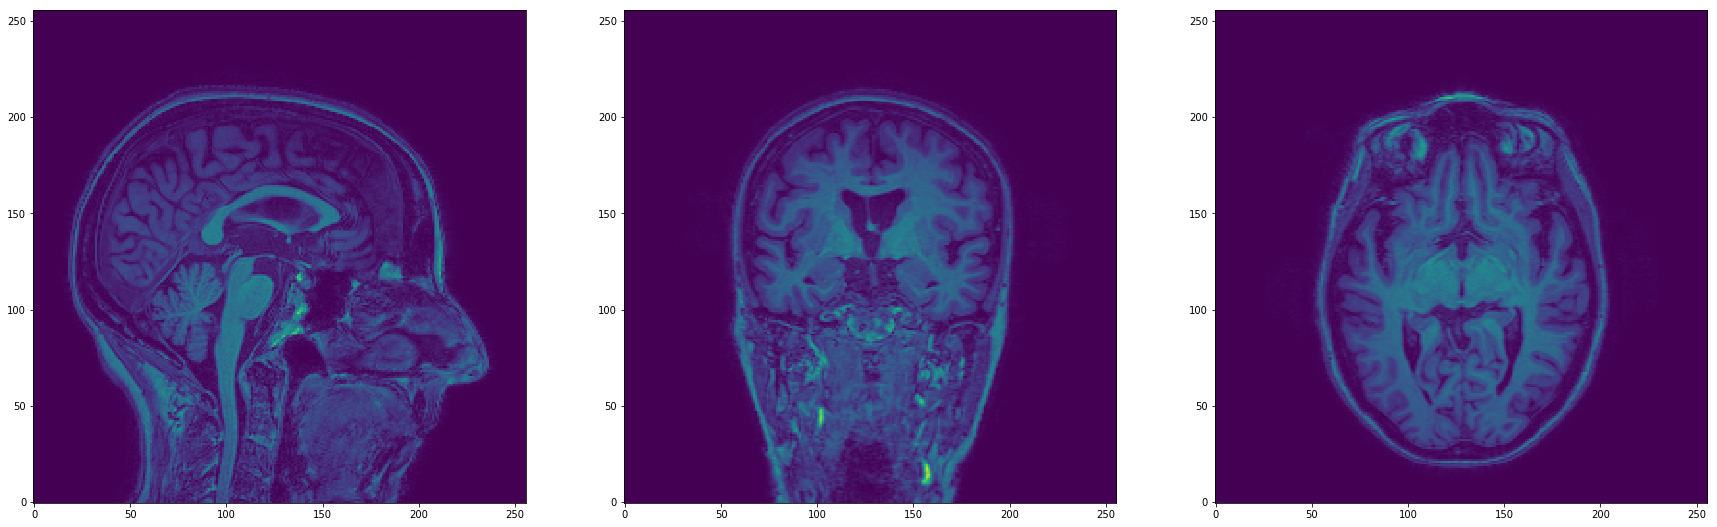

In [28]:
show_slices(np_img)

In [25]:
crop=((68,68),(50,86),(88,48))
zooms=.8
augment=True
shape=np_img.shape
n=16

x, y, z = shape[0], shape[1], shape[2] 
d1, d2, d3 = (x-crop[0][0]-crop[0][1]), (y-crop[1][0]-crop[1][1]), (z-crop[2][0]-crop[2][1])
shape_cropped = (n, d1, d2, d3)
shape_zoomed = (n, int(np.round(shape_cropped[1]*zooms)),int(np.round(shape_cropped[2]*zooms)),int(np.round(shape_cropped[3]*zooms)))

if augment:
    scan_data = ScanAugmentor().augment(np_img)
if crop != ((0,0),(0,0),(0,0)): 
    scan_cropped = np.empty((d1, d2, d3))
    scan_cropped[:,:,:] = scan_data[crop[0][0]:(x-crop[0][1]), crop[1][0]:(y-crop[1][1]), crop[2][0]:(z-crop[2][1])]
else:
    scan_cropped = scan_data

if zooms != 1:            
    scan_zoom = zoom(scan_cropped[:, :, :], zooms)
else:
    scan_zoom = scan_cropped

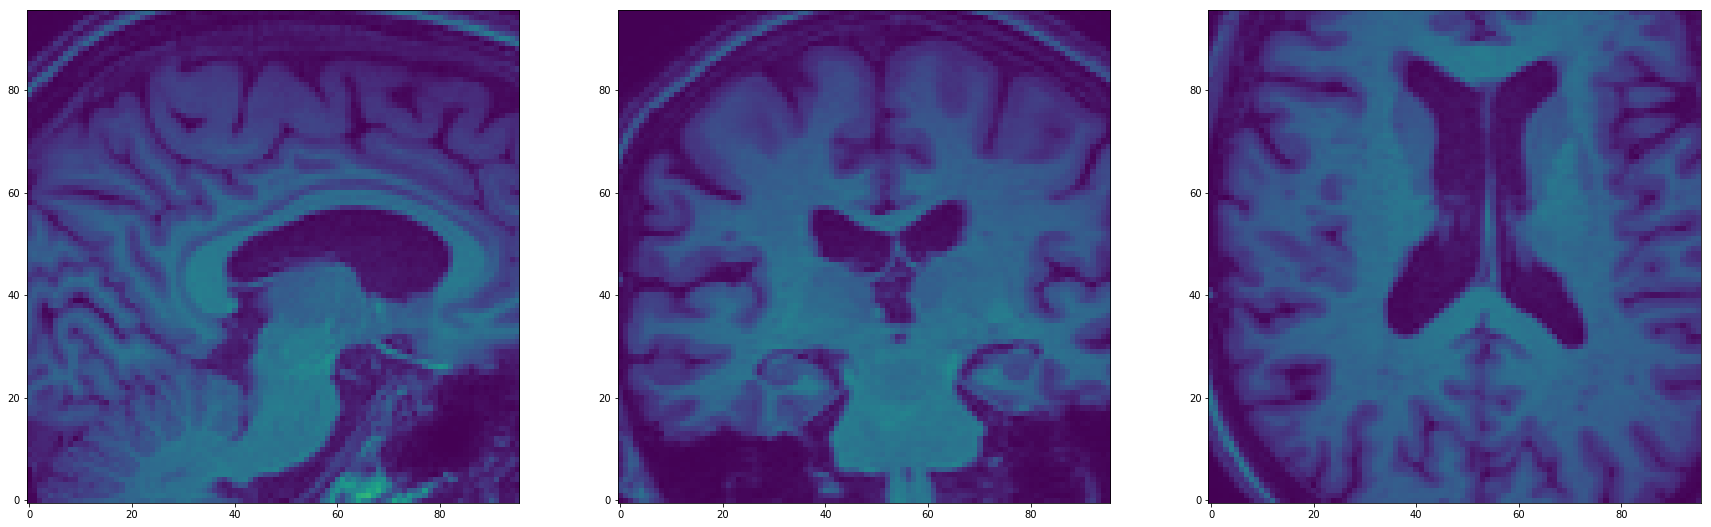

In [26]:
show_slices(scan_zoom)

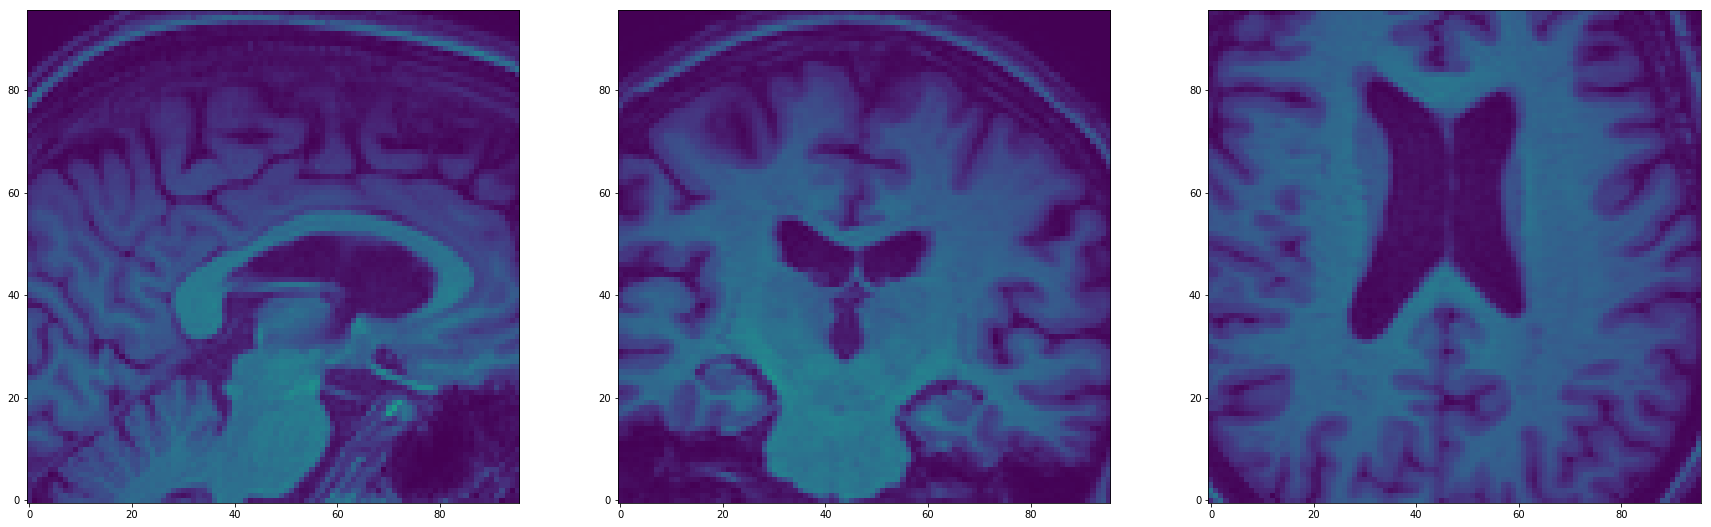

In [24]:
show_slices(scan_zoom)

In [18]:
print(shape_cropped,
shape_zoomed)

(16, 144, 144, 200) (16, 115, 115, 160)


144

In [15]:
scan_zoom.shape

(115, 115, 160)

In [26]:
df = pd.read_csv(get_directory.adni_mprage_snp_dataframe)

In [10]:
df.head()

,Subject_ID,Image_ID,Description,DX_Group,APOE_A1,APOE_A2,path,Sex,Weight,Study_Date
0,002_S_0413,14437,MP-RAGE,Normal,3.0,3.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,61.4,5/02/2006
1,002_S_0685,18210,MP-RAGE REPEAT,Normal,3.0,3.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,65.3,7/06/2006
2,002_S_0729,19057,MP-RAGE,LMCI,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,60.4,7/17/2006
3,002_S_1155,33393,MP-RAGE,LMCI,3.0,3.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,65.6,12/14/2006
4,002_S_1261,40502,MP-RAGE REPEAT,Normal,3.0,3.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,59.9,2/15/2007


In [11]:
df[df.DX_Group == 'AD']

,Subject_ID,Image_ID,Description,DX_Group,APOE_A1,APOE_A2,path,Sex,Weight,Study_Date
40,006_S_4153,248517,MPRAGE,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,70.0,8/03/2011
41,006_S_4192,258594,MPRAGE,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,80.0,9/27/2011
48,006_S_4546,287990,MPRAGE SENSE2,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,93.0,3/05/2012
115,014_S_4039,238745,MPRAGE,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,81.6,6/02/2011
125,014_S_4615,294334,MPRAGE,AD,3.0,3.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,88.9,3/29/2012
143,018_S_4696,301389,MPRAGE,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,80.0,5/01/2012
144,019_S_4252,258946,MPRAGE SENSE2,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,59.0,9/28/2011
148,019_S_4477,280783,MPRAGE,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,F,57.0,1/25/2012
150,019_S_4549,300335,MPRAGE,AD,2.0,3.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,84.0,4/23/2012
196,023_S_4501,291854,MPRAGE GRAPPA2,AD,3.0,4.0,/mnt/lippert01/mri_backup/adni/adni_mprage/ADN...,M,75.3,3/22/2012


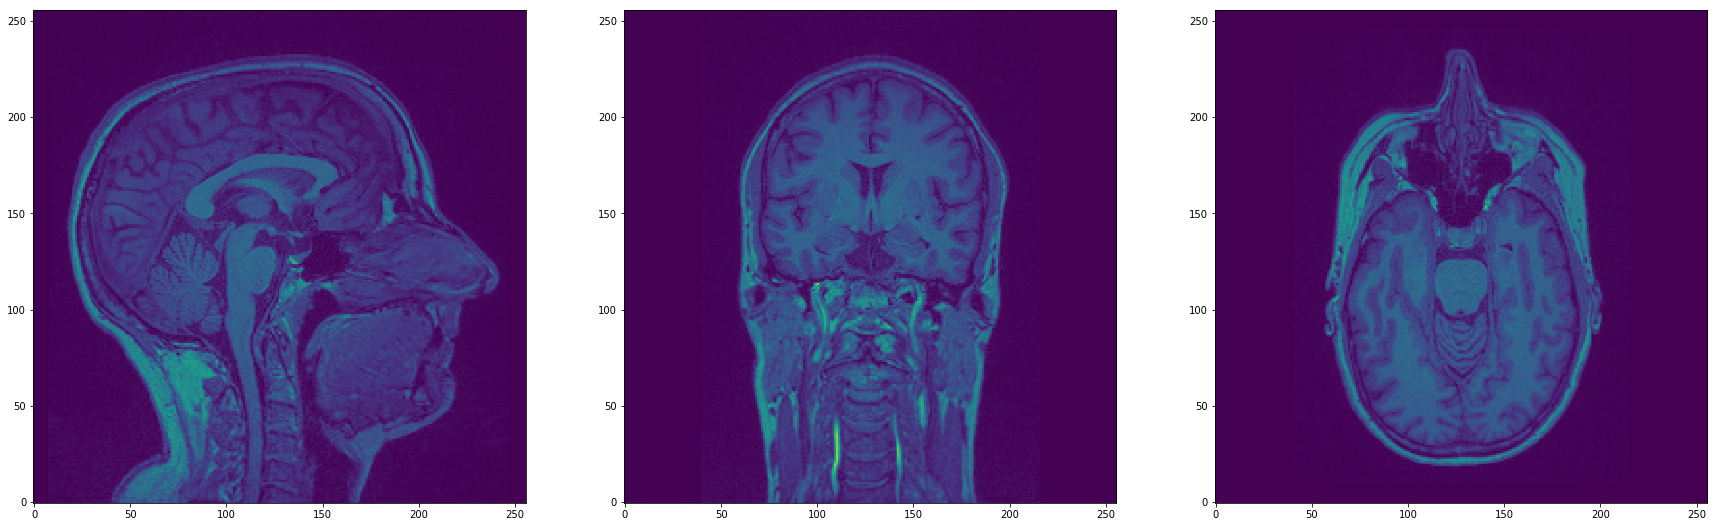

In [4]:
df =pd.read_csv(get_directory.adni_mprage_dataframe)
df.drop_duplicates(subset='Subject_ID',inplace=True)
with open(get_directory.adni_mprage_dict, 'rb') as pk:
            imgid = pickle.load(pk)
img = ScanDataGenerator(get_directory.adni_mprage_h5,img_id=df[df.DX_Group == 'Normal'].Image_ID[102:103],dataframe=get_directory.adni_mprage_dataframe,input_dim=(256,256,256),img_to_i=imgid)
np_img = np.array(img)

normal = np_img[0,0,0,:,:,:,0]
show_slices(normal,size=30)

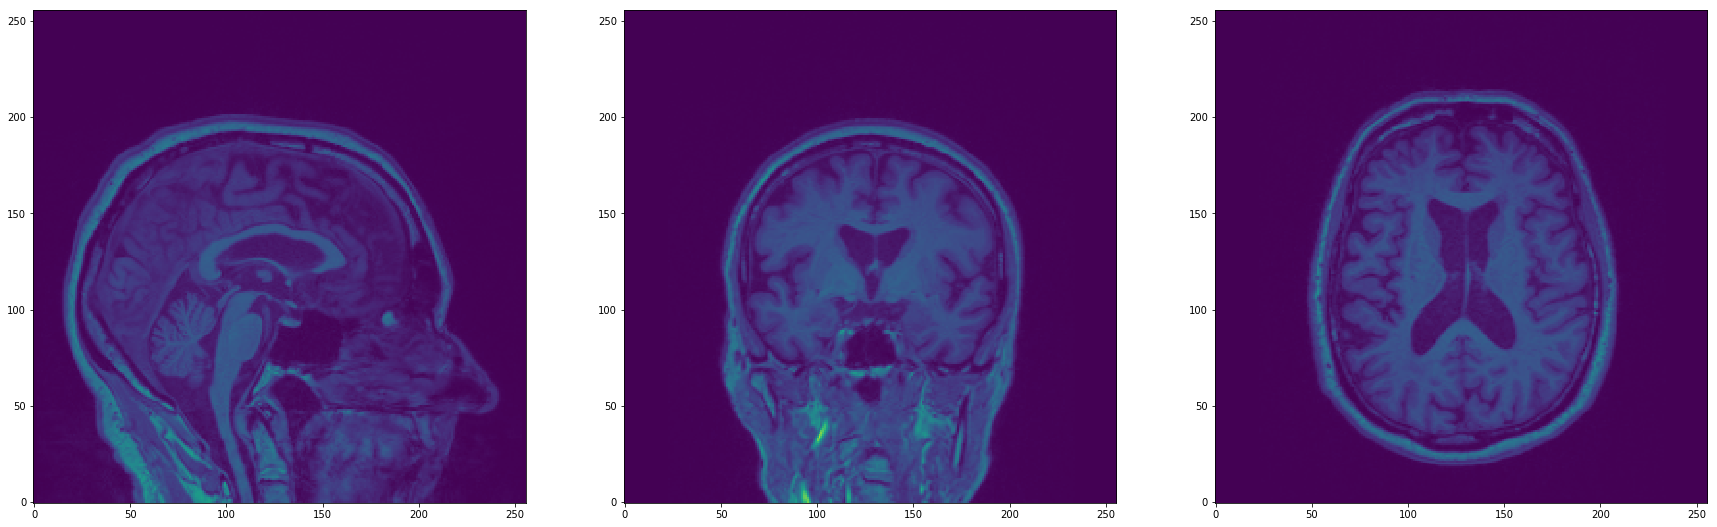

In [5]:
df =pd.read_csv(get_directory.adni_mprage_dataframe)
df.drop_duplicates(subset='Subject_ID',inplace=True)

with open(get_directory.adni_mprage_dict, 'rb') as pk:
            imgid = pickle.load(pk)
img = ScanDataGenerator(get_directory.adni_mprage_h5,img_id=df[df.DX_Group == 'AD'].Image_ID[206:207],dataframe=get_directory.adni_mprage_dataframe,input_dim=(256,256,256),img_to_i=imgid)
np_img = np.array(img)
ad = np_img[0,0,0,:,:,:,0]
show_slices(ad,size=30)

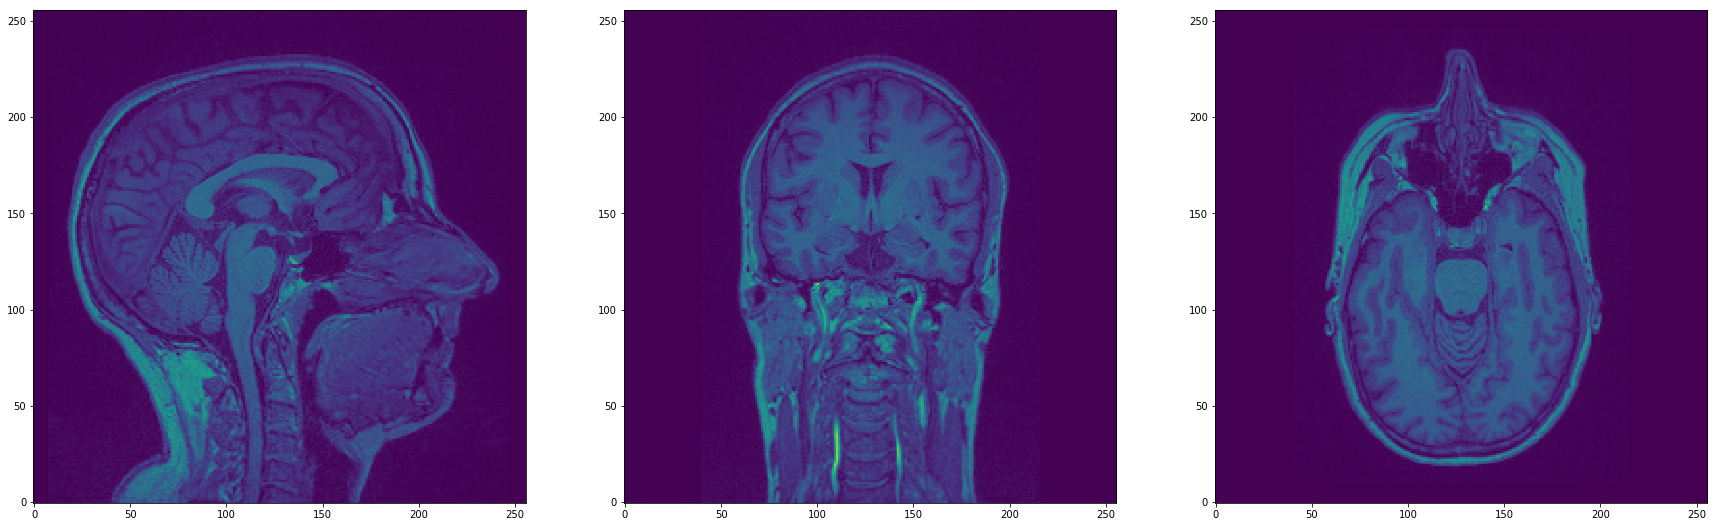

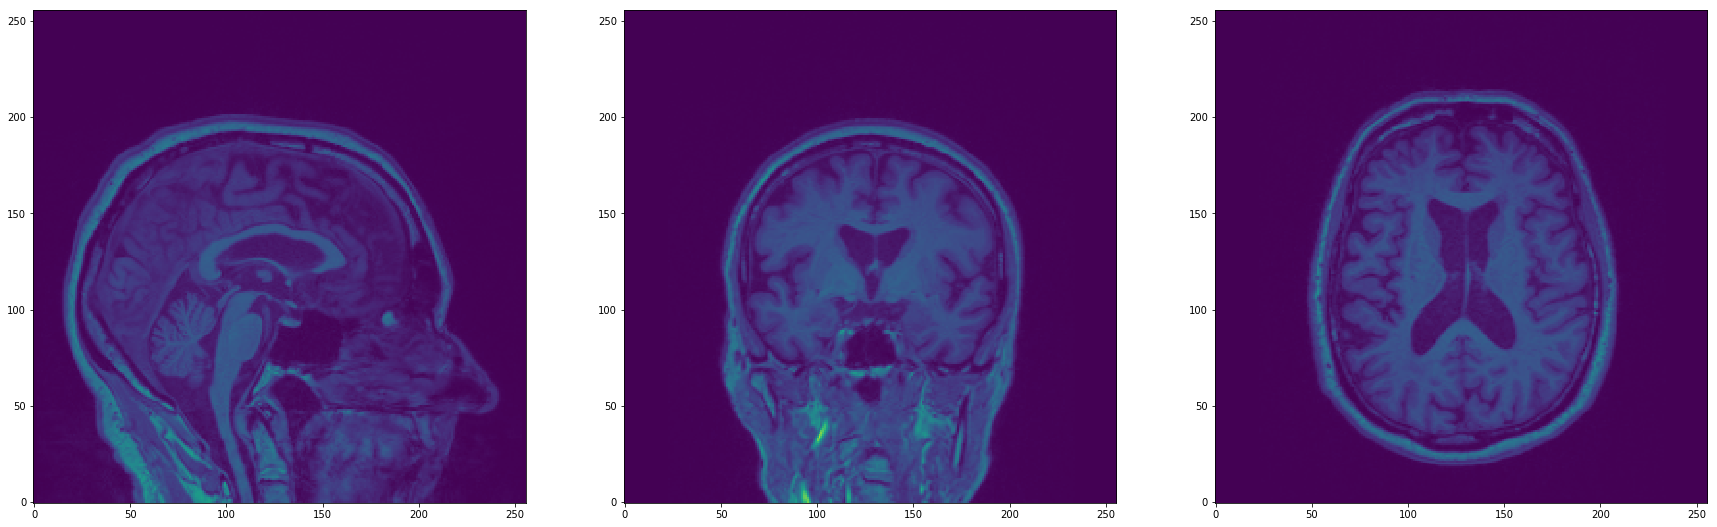

In [76]:
show_slices(normal,size=30)
show_slices(ad,size=30)

In [55]:
np_img.shape[0]

10

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def show_scan(scan, x=None, y=None, z=None, size=30, save_to=None): #scan: directory to a nifti file
    """ Function to display the middle slice in each axis of a scan """
    fig, axes = plt.subplots(1, 3, figsize=(size,size),sharey=True)
    if type(scan) == str: 
        scan = nib.load(scan)
        scan = scan.get_fdata()
    elif type(scan) == np.array:
        scan = scan
    if x:
        slice_x = scan[x,:,:]
    else:    
        slice_x = scan[int(scan.shape[0]/2),:,:]
    if y:
        slice_y = scan[:,y,:]
    else:
        slice_y = scan[:,int(scan.shape[1]/2),:]
    if z:
        slice_z = scan[:,:,z]
    else:
        slice_z = scan[:,:,int(scan.shape[2]/2)]
    slices = [slice_x, slice_y, slice_z]
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower", cmap='gray', vmin=0.,vmax=1.)
        axes[i].axis('off')
        plt.tight_layout(pad=0)
        plt.subplots_adjust(wspace=0.0,hspace=0.0)
        if save_to:
            plt.savefig(fname=save_to, quality =90)

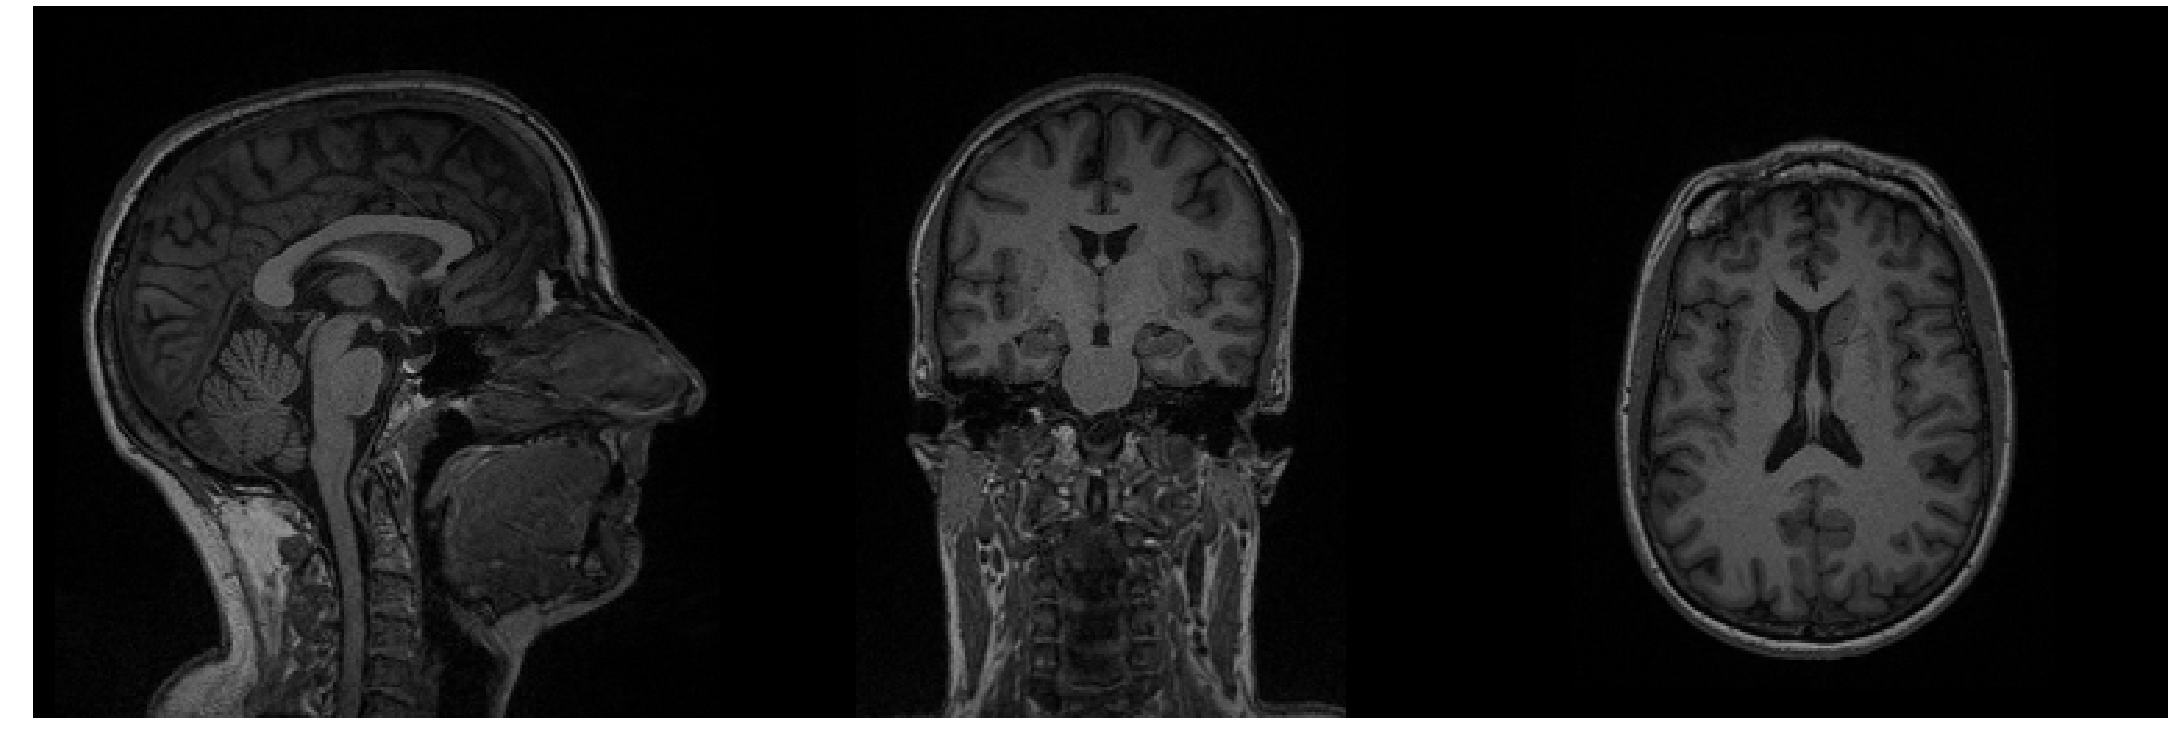

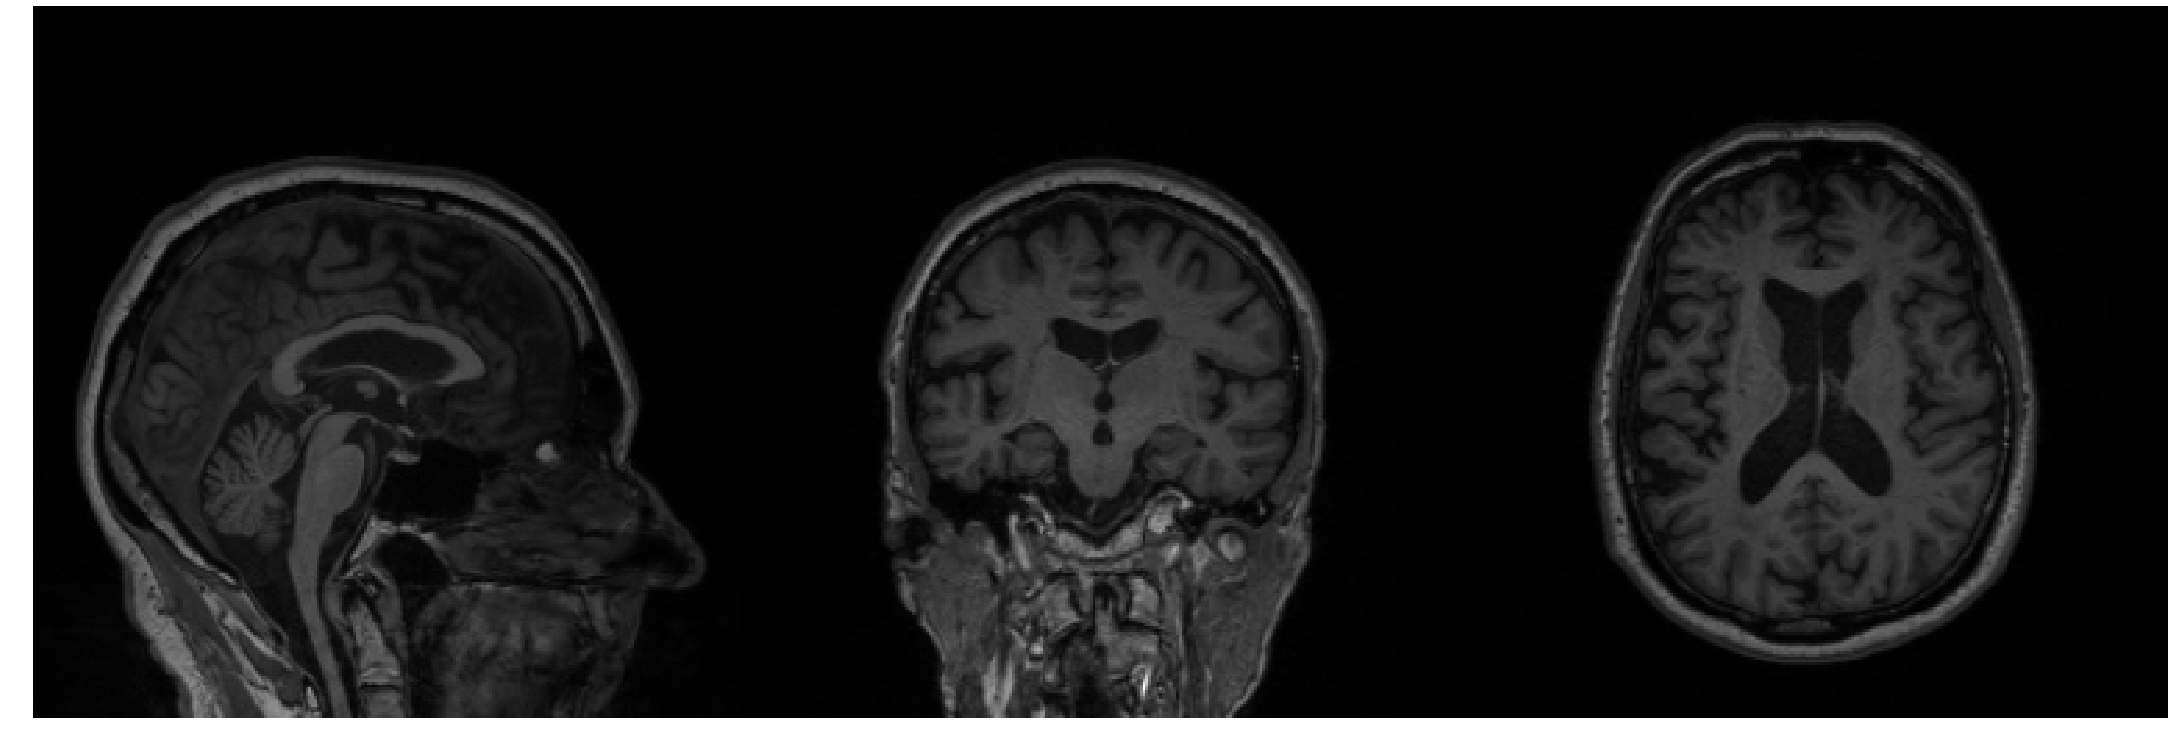

In [6]:
show_scan(normal,y=120, z=165, save_to='/home/skhorasani/deep_mmd_testing/deep-mmd-testing/mri_normal.png')
show_scan(ad,y=116,size=30, save_to='/home/skhorasani/deep_mmd_testing/deep-mmd-testing/mri_ad.png')